## Proyecto 


### 1. Librerías Usadas

In [27]:
import undetected_chromedriver as uc
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import nbformat
import ipywidgets as widgets
import plotly.io as pio
import os
import plotly.express as px


In [ ]:
# Ruta de archivo para guardar y obtener los datos en csv
data_csv = "data/Primor/data_primor_lujo.csv"

# Lista de url de las categorías de productos
categorias = [
        ("Hidratantes y Nutrivas", "https://www.primor.eu/es_es/hidratantes-y-nutritivas-lujo"),
        ("Antiarrugas y antiedad", "https://www.primor.eu/es_es/antiarrugas-y-antiedad-lujo"),
        ("Contorno de Ojos", "https://www.primor.eu/es_es/contorno-de-ojos-lujo"),
        ("Tratamientos especificos", "https://www.primor.eu/es_es/tratamientos-especificos-lujo"),
        ("limpiadoras tonicos", "https://www.primor.eu/es_es/limpiadoras-tonicos-lujo"),
        ("cofres", "https://www.primor.eu/es_es/cofres-lujo-1"),
        ("labios balsamos y cuidados", "https://www.primor.eu/es_es/labios-balsamos-y-cuidados-lujo"),
        ("Antimanchas", "https://www.primor.eu/es_es/antimanchas-lujo"),
        ("Exfoliantes", "https://www.primor.eu/es_es/exfoliantes-lujo"),
        ("Tratamientos calmantes", "https://www.primor.eu/es_es/tratamientos-calmantes-y-para-piel-sensible")
    ]

# Lista de parámetros de tipos de piel para construir la url de los productos
tipos_de_piel = [
        ("Normal", 66101),
        ("Deshidratada", 66094),
        ("Sensible", 66110), 
        ("Todo tipo de piel", 66111),
        ("Madura", 66097),
        ("Muy seca", 66100),
        ("seca", 66107),
        ("Grasa", 66096),
        ("Mixta", 66098),
        ("Mixta a Grasa", 66099),
        ("Normal a seca", 66104),
        ("seca-muy seca", 66109),
        ("seca - mixta", 66108),
        ("atopica", 66092),
        ("Delicadas", 66093),
        ("Apagadas", 66091)
    ]

 # Lista de parámetros de zonas de aplicación para construir la url de los productos   
zonas_aplicacion = [        
        ("Rostro", 66325),
        ("Cuerpo", 66309),
        ("Manos", 66315),
        ("Ojos", 66319),
        ("Cuello", 66308)      
    ]


### 2. Obteniendo la data con Scraping de la página web de PRIMOR

In [28]:
def connect_and_get_html(url):
    # ------------- Configurando Selenium -------------------------
    # Configuración de opciones para el navegador
    # Se utiliza ChromeDriverManager para instalar y gestionar el controlador de Chrome automáticamente. 
    
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # Ejecutar en modo headless (opcional)
    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    html = False # Inicializamos html como False para manejar el caso de error
    
    # Obteniendo la URL
    driver.get(url)
    
    # Verificando si existe el div con la clase "message info empty"
    try:
        empty_message = driver.find_element(By.CLASS_NAME, "message.info.empty")
        print(f"No hay productos en la página: {url}")
        driver.quit()
        return False
    except NoSuchElementException:
        # Si no se encuentra el div "message info empty", continuar con el scraping
        pass
    
    for attempt in range(3):  # Intentar hasta 3 veces
        try:
            driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
            driver.get(url)
            
            try:
                # Configurar WebDriverWait con sondeo personalizado e ignorar excepciones
                wait = WebDriverWait(driver, 15, poll_frequency=0.2, ignored_exceptions=[NoSuchElementException])
                
                # Esperar hasta que el elemento dinámico esté presente
                element = wait.until(
                    EC.presence_of_element_located((By.CLASS_NAME, "pr-stars"))
                )
                print("Elemento encontrado:", element.get_attribute("style"))
                
                # Obtener el HTML renderizado
                html = driver.page_source
            except TimeoutException:
                print("El elemento 'pr-stars' no se cargó en el tiempo esperado.")
                driver.quit()
                return False
            finally:
                driver.quit()
            
            break  # Salir del bucle si tiene éxito
        except Exception as e:
            print(f"Error en intento {attempt + 1}: {e}")
            time.sleep(5)  # Esperar antes de reintentar
        finally:
            driver.quit()

    return html

In [29]:
def scraping_pagina(url, output_df, categoria, tipo_piel, zona_aplicacion):
    
    # Conectar y obtener el HTML de la página
    html = connect_and_get_html(url)
    
    if not html:
        print(f"Error al obtener el HTML de la página: {url}")
        return output_df        
    
    # Usar BeautifulSoup para analizar el HTML
    soup = BeautifulSoup(html, "html.parser")
    
    # Buscar todos los <li> dentro de un <ul>
    lista_items = soup.find_all("li")
    
    # Listas para almacenar los datos extraídos
    marcas_producto = []
    descripciones_producto = []
    calificaciones_producto = []
    total_calificadores = []
    precios_producto = []
    categorias_producto = []
    tipos_piel = []
    zonas_aplicacion = []
    
    for li in lista_items:
        # Buscar <form> dentro del <li>
        form = li.find("form")
        if form:
            
            categorias_producto.append(categoria)
            tipos_piel.append(tipo_piel)
            zonas_aplicacion.append(zona_aplicacion)
            
            # Buscar <div> con la clase específica dentro del <form>
            div = form.find("div", class_="text-sm font-bold uppercase")
           
            marcas_producto.append(div.get_text(strip=True) if div else None)  # Extraer el texto del <div> o agregar un valor nulo si no existe
            
            # Buscar <a> con la clase específica dentro del <form>
            a = form.find("a", class_="product-item-link inline-block text-sm leading-4")
            descripciones_producto.append(a.get_text(strip=True) if a else None)  # Extraer el texto del <a> o agregar un valor nulo si no existe
            
            # Buscar <span> con la clase específica para precios
            span_precio = form.find("span", class_="price-wrapper")
            precios_producto.append(span_precio.get_text(strip=True) if span_precio else None)  # Extraer el texto del <span> o agregar un valor nulo si no existe
    
            # Buscar <div> con la clase específica para calificaciones
            div2 = form.find("div", class_="pr-stars")
            if div2:
                calificaciones_producto.append(div2.get("style"))  # Extraer el atributo 'style'
                span = div2.find("span")
                total_calificadores.append(span.get_text(strip=True) if span else None)
            else:
                calificaciones_producto.append(None)  # Si no hay <div>, agregar un valor nulo
                total_calificadores.append(None)
            
            
    # Crear un DataFrame con las columnas
    precios_producto = [precio.replace("€", "").replace(",", ".").strip() if precio else None for precio in precios_producto]
    df = pd.DataFrame({
        "marca": marcas_producto,
        "descripcion": descripciones_producto,
        "calificacion": calificaciones_producto,
        "total_calificadores": total_calificadores,
        "precio": precios_producto,
        "categoria": categorias_producto,
        "tipo_piel": tipos_piel,
        "zona_aplicacion": zonas_aplicacion
    })
    
    #Concatenamos los resultados de la página actual con los resultados de las páginas anteriores
    output_df = pd.concat([output_df, df], ignore_index=True)
    return output_df

In [ ]:
def sraping_webSite(categorias, tipos_de_piel, zonas_aplicacion, output_csv):
    output_df = pd.DataFrame(columns=["marca", "descripcion", "calificacion", "total_calificadores", "precio", "categoria", "tipo_piel","zona_aplicacion"])
    
    
    # Recorrer las categorías y tipos de piel
    for categoria, url_categoria in categorias:
        print(f"\nCategoría: {categoria}")
        
        for tipo_piel, codigo in tipos_de_piel:
            print(f"\n  Tipo de piel: {tipo_piel}")
            for zona, codigo_zona in zonas_aplicacion:
                print(f"\n   Zona de aplicación: {zona}")
                
                for pagina in range(1, 3):  # Cambia el rango según el número de páginas que se va recorrer
                    # Concatenar el código del tipo de piel como parámetro en la URL
                    url_con_parametro = f"{url_categoria}?tipo_piel={codigo}&zona_cara={codigo_zona}&p={pagina}"
                    print(f"    URL: {url_con_parametro}")
            
                    output_df = scraping_pagina(url_con_parametro, output_df, categoria, tipo_piel, zona)
                
        if output_df is None or output_df.empty:
            print(f"Advertencia: No se encontraron datos para la categoría {categoria}.")
        else:
            # output_csv = f"data/Primor/data_primor_lujo.csv"           
            output_df.to_csv(output_csv, mode='w', header=True, index=False, encoding="utf-8")
            print(f"Datos exportados a {output_csv}")
        
    return output_df           




In [ ]:

# df_primor = sraping_webSite(categorias, tipos_de_piel, zonas_aplicacion, data_csv)
# df_primor


Categoría: Hidratantes y Nutrivas

  Tipo de piel: Normal

   Zona de aplicación: Rostro
    URL: https://www.primor.eu/es_es/hidratantes-y-nutritivas-lujo?tipo_piel=66101&zona_cara=66325&p=1
Elemento encontrado: --stars: 4.69;
    URL: https://www.primor.eu/es_es/hidratantes-y-nutritivas-lujo?tipo_piel=66101&zona_cara=66325&p=2
No hay productos en la página: https://www.primor.eu/es_es/hidratantes-y-nutritivas-lujo?tipo_piel=66101&zona_cara=66325&p=2
Error al obtener el HTML de la página: https://www.primor.eu/es_es/hidratantes-y-nutritivas-lujo?tipo_piel=66101&zona_cara=66325&p=2
Datos exportados a data/Primor/data_primor_lujo.csv


,marca,descripcion,calificacion,total_calificadores,precio,categoria,tipo_piel,zona_aplicacion
0,Elizabeth Arden,Visible Difference Crema Hidratante,--stars:4.69,(77),52.00,Hidratantes y Nutrivas,Normal,Rostro
1,Kiehl's,Ultra Facial Oil-Free Gel Cream Crema Hidratante,--stars:4.82,(51),22.00,Hidratantes y Nutrivas,Normal,Rostro
2,Clinique,Moisture Surge Crema Hidratante con Color SPF 25,--stars:5.00,(4),39.00,Hidratantes y Nutrivas,Normal,Rostro
3,Origins,Ginzing SPF 40 Energy-Boosting Tinted Moisturizer,--stars:4.75,(4),44.00,Hidratantes y Nutrivas,Normal,Rostro
4,Clarins,Multi-Intensiva Crema de Día Todo Tipo de Piel,--stars:4.88,(48),130.00,Hidratantes y Nutrivas,Normal,Rostro
5,Elizabeth Arden,8 Hour Cream Hidratante de Noche,--stars:3.67,(6),49.00,Hidratantes y Nutrivas,Normal,Rostro
6,Clinique,Clinique For Men Maximum Hydrator Gel Hidratante,--stars:5.00,(1),51.00,Hidratantes y Nutrivas,Normal,Rostro
7,Clarins,Rose Radiance Crema Multi-Intensiva,--stars:4.33,(6),130.00,Hidratantes y Nutrivas,Normal,Rostro
8,Dior,DIOR HYDRA LIFE Crème Sorbet Intense Crema Hid...,--stars:5.00,(1),75.10,Hidratantes y Nutrivas,Normal,Rostro
9,Dior,DIOR HYDRA LIFE Crème Sorbet Fraîcheur Crema H...,--stars:5.00,(2),75.10,Hidratantes y Nutrivas,Normal,Rostro


### 3. Importando la Data obtenida

In [ ]:
# Cargar el archivo CSV en un DataFrame
df_cosmeticos = pd.read_csv(data_csv, sep=",", encoding="utf-8")


# Mostrar las primeras filas del DataFrame
df_cosmeticos.head(5)

,marca,descripcion,calificacion,total_calificadores,precio,categoria,tipo_piel,zona_aplicacion
0,Anne Moller,Rosâge Hyaluronic Acid Gel Concentrado,--stars:4.75,(4),41.00,Antiarrugas y antiedad,Sensible,Rostro
1,Kiehl's,Micro-Dose Anti-Aging Retinol Serum with Ceram...,--stars:4.78,(127),57.00,Antiarrugas y antiedad,Sensible,Rostro
2,It Cosmetics,Confidence Crema Antiedad Hidratante,--stars:5.00,(1462),65.00,Antiarrugas y antiedad,Sensible,Rostro
3,Kiehl's,Super Multi-Corrective Cream Crema Reafirmante...,--stars:4.95,(75),80.00,Antiarrugas y antiedad,Sensible,Rostro
4,Lancôme,Nutrix Royal Crema Nutritiva,--stars:5.00,(6),77.00,Antiarrugas y antiedad,Sensible,Rostro


## 4. Limpieza de Datos

In [24]:
def limpieza_datos(df_cosmeticos):
    # Mostrar información del DataFrame antes de la limpieza
    print("------------------------------------------------------")
    print("Información del DataFrame antes de la limpieza:")
    print("------------------------------------------------------")
    df_cosmeticos.info()
    
    # Nos aseguramos de trabajar sobre una copia del dataframe original
    df_cosmeticos = df_cosmeticos.copy()
    
    # Eliminar filas donde 'calificacion' o 'total_calificadores' son nulos:
    df_cosmeticos = df_cosmeticos.dropna(subset=['calificacion', 'total_calificadores'])

    # Convertir la columna "precio" a tipo numérico
    df_cosmeticos["precio"] = pd.to_numeric(df_cosmeticos["precio"], errors="coerce")
    
    # Eliminar filas con valores nulos en la columna "precio"
    df_cosmeticos.dropna(subset=["precio"])
    
    # Limpiando la columna 'calificacion'
    df_cosmeticos['calificacion'] = df_cosmeticos['calificacion'].str.replace(r'^--stars:', '', regex=True).astype(float)

    # Limpiando la columna 'total_calificadores'
    df_cosmeticos['total_calificadores'] = df_cosmeticos['total_calificadores'].str.replace(r'[()]', '', regex=True)
    
    # Verificar el resultado
    print("------------------------------------------------------")
    print("Información del DataFrame después de la limpieza:")
    print("------------------------------------------------------")
    df_cosmeticos.info()
    
    return df_cosmeticos
    

In [25]:
df_cosmeticos = limpieza_datos(df_cosmeticos)
df_cosmeticos.head(5)

------------------------------------------------------
Información del DataFrame antes de la limpieza:
------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   marca                1104 non-null   object
 1   descripcion          1104 non-null   object
 2   calificacion         686 non-null    object
 3   total_calificadores  686 non-null    object
 4   precio               1104 non-null   object
 5   categoria            1104 non-null   object
 6   tipo_piel            1104 non-null   object
 7   zona_aplicacion      1104 non-null   object
dtypes: object(8)
memory usage: 69.1+ KB
------------------------------------------------------
Información del DataFrame después de la limpieza:
------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 

,marca,descripcion,calificacion,total_calificadores,precio,categoria,tipo_piel,zona_aplicacion
0,Anne Moller,Rosâge Hyaluronic Acid Gel Concentrado,4.75,4,41.0,Antiarrugas y antiedad,Sensible,Rostro
1,Kiehl's,Micro-Dose Anti-Aging Retinol Serum with Ceram...,4.78,127,57.0,Antiarrugas y antiedad,Sensible,Rostro
2,It Cosmetics,Confidence Crema Antiedad Hidratante,5.00,1462,65.0,Antiarrugas y antiedad,Sensible,Rostro
3,Kiehl's,Super Multi-Corrective Cream Crema Reafirmante...,4.95,75,80.0,Antiarrugas y antiedad,Sensible,Rostro
4,Lancôme,Nutrix Royal Crema Nutritiva,5.00,6,77.0,Antiarrugas y antiedad,Sensible,Rostro


## 5. Transformando los datos :

In [11]:
# Capitalizar la primera letra de los nombres de las columnas
df_cosmeticos.columns = df_cosmeticos.columns.str.capitalize()

# renombrando la columna 'Precio' a 'Precio (€)'
df_cosmeticos = df_cosmeticos.rename(columns={'Precio': 'Precio_Euros'})

# Asegurar que los valores se mantengan como números.
df_cosmeticos['Precio_Euros'] = df_cosmeticos['Precio_Euros'].astype(float)
df_cosmeticos.head(5)

,Marca,Descripcion,Calificacion,Total_calificadores,Precio_Euros,Categoria,Tipo_piel,Zona_aplicacion
0,Anne Moller,Rosâge Hyaluronic Acid Gel Concentrado,4.75,4,41.0,Antiarrugas y antiedad,Sensible,Rostro
1,Kiehl's,Micro-Dose Anti-Aging Retinol Serum with Ceram...,4.78,127,57.0,Antiarrugas y antiedad,Sensible,Rostro
2,It Cosmetics,Confidence Crema Antiedad Hidratante,5.00,1462,65.0,Antiarrugas y antiedad,Sensible,Rostro
3,Kiehl's,Super Multi-Corrective Cream Crema Reafirmante...,4.95,75,80.0,Antiarrugas y antiedad,Sensible,Rostro
4,Lancôme,Nutrix Royal Crema Nutritiva,5.00,6,77.0,Antiarrugas y antiedad,Sensible,Rostro


In [12]:
# Convirtiendo las columnas a los tipos de datos adecuados
df_cosmeticos['Calificacion'] = df_cosmeticos['Calificacion'].astype(float)
df_cosmeticos['Precio_Euros'] = df_cosmeticos['Precio_Euros'].astype(float)
df_cosmeticos['Total_calificadores'] = df_cosmeticos['Total_calificadores'].astype(int)
df_cosmeticos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 686 entries, 0 to 1103
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Marca                686 non-null    object 
 1   Descripcion          686 non-null    object 
 2   Calificacion         686 non-null    float64
 3   Total_calificadores  686 non-null    int64  
 4   Precio_Euros         686 non-null    float64
 5   Categoria            686 non-null    object 
 6   Tipo_piel            686 non-null    object 
 7   Zona_aplicacion      686 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 48.2+ KB


## 6. Análisis Estadístico de los Datos (EDA)

In [13]:
df_cosmeticos.describe()

,Calificacion,Total_calificadores,Precio_Euros
count,686.000000,686.000000,686.000000
mean,4.726458,24.227405,100.372055
std,0.450243,121.014534,89.336825
min,1.000000,1.000000,11.000000
25%,4.650000,2.000000,46.000000
50%,4.880000,4.000000,69.100000
75%,5.000000,10.000000,130.000000
max,5.000000,1462.000000,509.000000


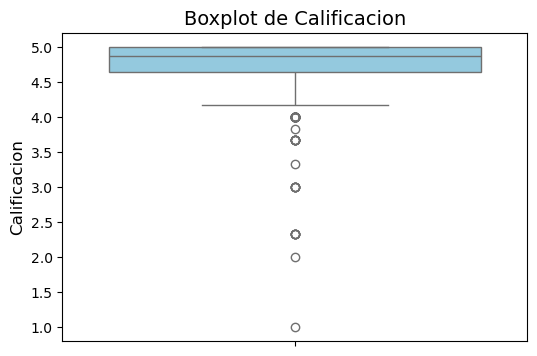

In [14]:
# Boxplot para la columna 'Calificacion'
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_cosmeticos, y='Calificacion', color='skyblue')
plt.title("Boxplot de Calificacion", fontsize=14)
plt.ylabel("Calificacion", fontsize=12)
plt.xlabel("")
plt.show()



Como podemos observar la mayoría de las calificaciones se encuentran entre 4.5 y 5 estrellas

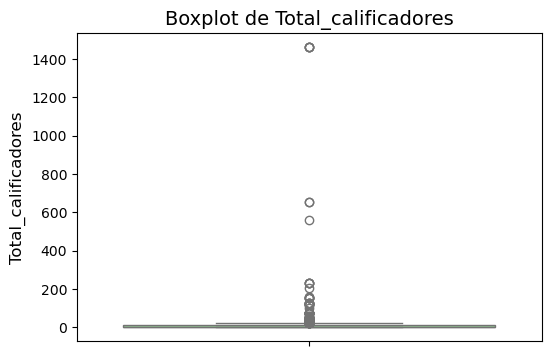

In [15]:
# Boxplot para la columna 'Total_calificadores'
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_cosmeticos, y='Total_calificadores', color='lightgreen')
plt.title("Boxplot de Total_calificadores", fontsize=14)
plt.ylabel("Total_calificadores", fontsize=12)
plt.xlabel("")
plt.show()



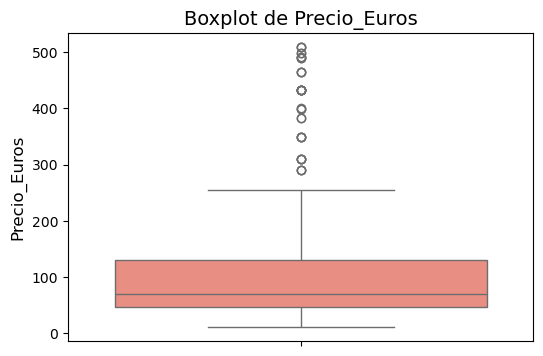

In [16]:
# Boxplot para la columna 'Precio_Euros'
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_cosmeticos, y='Precio_Euros', color='salmon')
plt.title("Boxplot de Precio_Euros", fontsize=14)
plt.ylabel("Precio_Euros", fontsize=12)
plt.xlabel("")
plt.show()

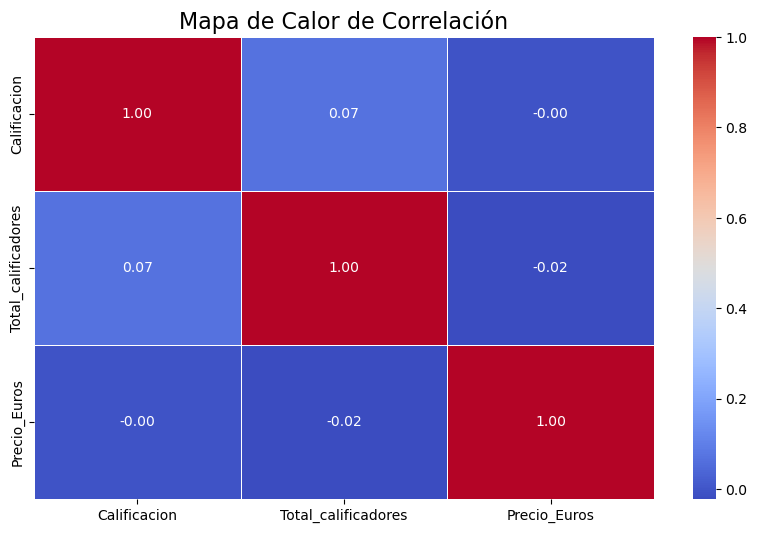

In [17]:
# Generar el mapa de calor de correlación
plt.figure(figsize=(10, 6))
# Seleccionar solo las columnas numéricas para calcular la matriz de correlación
correlacion = df_cosmeticos.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Personalizar el título
plt.title("Mapa de Calor de Correlación", fontsize=16)
plt.show()

No existe correlación entre calificacion, Total_calificadores y Precio

In [18]:
import plotly.express as px

# Obtener los datos de las 10 marcas más frecuentes
top_marcas = df_cosmeticos['Marca'].value_counts().head(10).reset_index()
top_marcas.columns = ['Marca', 'Frecuencia']

# Crear el gráfico de barras interactivo
fig = px.bar(
    top_marcas,
    x='Marca',
    y='Frecuencia',
    title="Top 10 Marcas Más Frecuentes",
    labels={'Frecuencia': 'Frecuencia', 'Marca': 'Marca'},
    #text='Frecuencia'  # Mostrar los valores en las barras
)

# Personalizar el diseño
fig.update_traces(textposition='outside', marker_color='purple')
fig.update_layout(
    xaxis_title="Marca",
    yaxis_title="Frecuencia",
    title_font_size=30,
    xaxis_tickangle=45
)

# Mostrar el gráfico
fig.show()

La marca Clarins aparece mas veces en el dataset, porque tiene varios productos que se adaptan a diferentes tipos de piel, zonas de aplicación y categorías de uso.

In [28]:
# Calcular la proporción de tipos de piel
tipo_piel_data = df_cosmeticos['Tipo_piel'].value_counts(normalize=True).reset_index()
tipo_piel_data.columns = ['Tipo_piel', 'Proporción']

# Crear el gráfico de pastel interactivo
fig = px.pie(
    tipo_piel_data,
    names='Tipo_piel',
    values='Proporción',
    title="Proporción de productos por Tipos de Piel",
    color_discrete_sequence=px.colors.qualitative.Pastel
)

# Personalizar el diseño
fig.update_traces(
    textinfo='none',  # Quitar etiquetas numéricas de las porciones
    hovertemplate='%{label}: %{percent}',  # Mostrar valores en porcentaje al pasar el mouse
)

fig.update_layout(title_font_size=16)

# Mostrar el gráfico
fig.show()

In [20]:
# Segmentación por categoría
for categoria, grupo in df_cosmeticos.groupby('Categoria'):
    print(f"Análisis para la categoría: {categoria}")
    print(grupo[['Calificacion', 'Precio_Euros']].describe())

Análisis para la categoría: Antiarrugas y antiedad
       Calificacion  Precio_Euros
count    182.000000    182.000000
mean       4.733681    149.319725
std        0.420132    110.565130
min        2.330000     22.500000
25%        4.670000     77.000000
50%        4.860000    122.000000
75%        5.000000    170.000000
max        5.000000    509.000000
Análisis para la categoría: Antimanchas
       Calificacion  Precio_Euros
count     13.000000     13.000000
mean       4.800000     76.846154
std        0.234769     40.682912
min        4.500000     37.000000
25%        4.500000     49.500000
50%        4.970000     65.000000
75%        5.000000    109.000000
max        5.000000    147.000000
Análisis para la categoría: Contorno de Ojos
       Calificacion  Precio_Euros
count     40.000000     40.000000
mean       4.545500    100.807000
std        0.527374     64.440604
min        2.000000     33.990000
25%        4.410000     53.000000
50%        4.620000     86.000000
75%        4.8

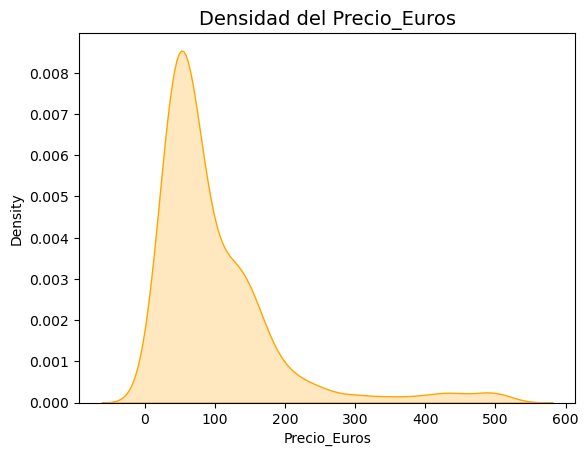

In [21]:
# Gráfico de densidad para el precio
sns.kdeplot(data=df_cosmeticos, x='Precio_Euros', fill=True, color='orange')
plt.title("Densidad del Precio_Euros", fontsize=14)
plt.xlabel("Precio_Euros")
plt.show()

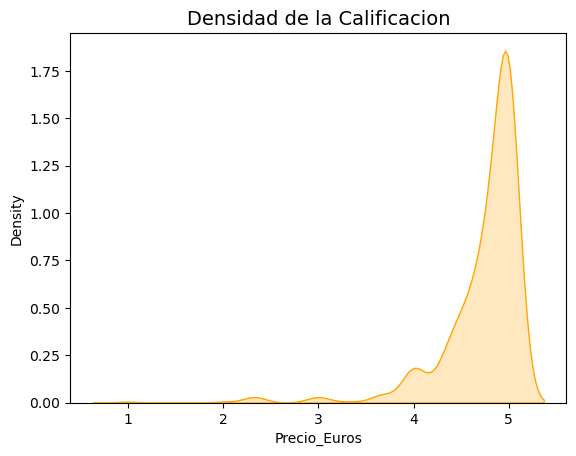

In [22]:
# Gráfico de densidad para el Calificacion
sns.kdeplot(data=df_cosmeticos, x='Calificacion', fill=True, color='orange')
plt.title("Densidad de la Calificacion", fontsize=14)
plt.xlabel("Precio_Euros")
plt.show()

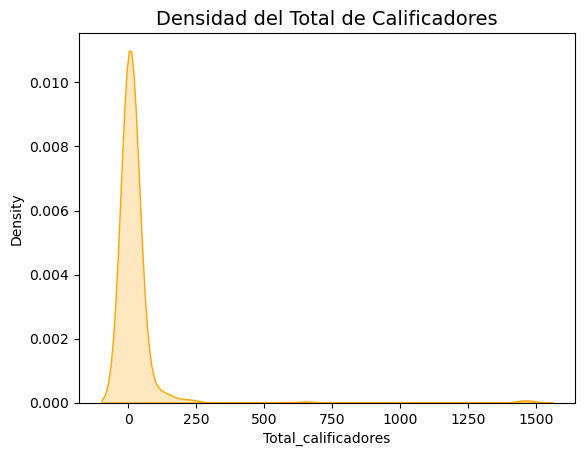

In [23]:
# Gráfico de densidad para el Total_calificadores
sns.kdeplot(data=df_cosmeticos, x='Total_calificadores', fill=True, color='orange')
plt.title("Densidad del Total de Calificadores", fontsize=14)
plt.xlabel("Total_calificadores")
plt.show()

## 7. Formulación de Hipótesis

In [24]:
from scipy.stats import ttest_ind

# Hipotesis planteada: Las calificaciones de los productos de las categorías 
# "Hidratantes y Nutrivas" y "Antiarrugas y antiedad" son iguales.

cat1 = "Hidratantes y Nutrivas"
cat2 = "Antiarrugas y antiedad"

grupo1 = df_cosmeticos[df_cosmeticos["Categoria"] == cat1]["Calificacion"]
grupo2 = df_cosmeticos[df_cosmeticos["Categoria"] == cat2]["Calificacion"]

# Prueba t
t_stat, p_value = ttest_ind(grupo1, grupo2, equal_var=False)  # Welch’s t-test

print(f"t = {t_stat:.3f}, p = {p_value:.3f}")
if p_value < 0.05:
    print("Rechazamos la hipótesis nula: hay diferencia significativa.")
else:
    print("No se rechaza la hipótesis nula: no hay diferencia significativa.")
    
   


t = -0.426, p = 0.671
No se rechaza la hipótesis nula: no hay diferencia significativa.


Los resultados muestran que la hipótesis planteada es probable y no se puede rechazar, por lo tanto
podríamos afirmar que las calificaciones de las cremas de estas categorías no tienen diferencia significativa.

In [ ]:
from scipy.stats import pearsonr

# Validando, si las calificaciones de los productos dependen del precio
# Hipostesis: "Las calificaciones estan relacionadas con los precios de los productos"

r, p = pearsonr(df_cosmeticos["Precio_Euros"], df_cosmeticos["Calificacion"])
print(f"Coeficiente de correlación: r = {r:.3f}, p = {p:.3f}")

if p < 0.05:
    print("Rechazamos H₀: hay una correlación significativa.")
else:
    print("No se rechaza H₀: no hay correlación significativa.")


Coeficiente de correlación: r = -0.003, p = 0.931
No se rechaza H₀: no hay correlación significativa.


De acuerdo a los resultados las calificaciones no tienen correlación significativa con el precio.

## 8. Modelo

In [ ]:
import sqlite3

# Conexión a la base de datos SQLite
conexion = sqlite3.connect('data/modeloEstrella/modelo_estrella.db')

# Guardar el dataframe completo tal como está
df_cosmeticos.to_sql('staging_data', conexion, if_exists='replace', index=False)


686

In [ ]:
sql_script = """
-- TABLA DE DIMENSIÓN: MARCA
CREATE TABLE dim_marca (
    id_marca INTEGER PRIMARY KEY,
    marca VARCHAR(255)
);
INSERT INTO dim_marca (marca, id_marca)
SELECT marca, ROW_NUMBER() OVER () AS id_marca
FROM (
    SELECT DISTINCT Marca AS marca
    FROM staging_data
) AS t;

-- TABLA DE DIMENSIÓN: CATEGORÍA
CREATE TABLE dim_categoria (
    id_categoria INTEGER PRIMARY KEY,
    categoria VARCHAR(255)
);
INSERT INTO dim_categoria (categoria, id_categoria)
SELECT categoria, ROW_NUMBER() OVER () AS id_categoria
FROM (
    SELECT DISTINCT Categoria AS categoria
    FROM staging_data
) AS t;

-- TABLA DE DIMENSIÓN: TIPO DE PIEL
CREATE TABLE dim_tipo_piel (
    id_tipo_piel INTEGER PRIMARY KEY,
    tipo_piel VARCHAR(255)
);
INSERT INTO dim_tipo_piel (tipo_piel, id_tipo_piel)
SELECT tipo_piel, ROW_NUMBER() OVER () AS id_tipo_piel
FROM (
    SELECT DISTINCT Tipo_piel AS tipo_piel
    FROM staging_data
) AS t;

-- TABLA DE DIMENSIÓN: ZONA DE APLICACIÓN
CREATE TABLE dim_zona_aplicacion (
    id_zona INTEGER PRIMARY KEY,
    zona_aplicacion VARCHAR(255)
);
INSERT INTO dim_zona_aplicacion (zona_aplicacion, id_zona)
SELECT zona_aplicacion, ROW_NUMBER() OVER () AS id_zona
FROM (
    SELECT DISTINCT Zona_aplicacion AS zona_aplicacion
    FROM staging_data
) AS t;

-- TABLA DE DIMENSIÓN: PRODUCTO
CREATE TABLE dim_producto (
    id_producto INTEGER PRIMARY KEY,
    nombre_producto VARCHAR(255)
);
INSERT INTO dim_producto (nombre_producto, id_producto)
SELECT nombre_producto, ROW_NUMBER() OVER () AS id_producto
FROM (
    SELECT DISTINCT Descripcion AS nombre_producto
    FROM staging_data
) AS t;

-- TABLA DE HECHOS: PRODUCTOS
CREATE TABLE hechos_productos (
    id_marca INTEGER,
    id_categoria INTEGER,
    id_tipo_piel INTEGER,
    id_zona INTEGER,
    id_producto INTEGER,
    Calificacion REAL,
    Total_calificadores INTEGER,
    Precio_Euros REAL,
    FOREIGN KEY (id_marca) REFERENCES dim_marca(id_marca),
    FOREIGN KEY (id_categoria) REFERENCES dim_categoria(id_categoria),
    FOREIGN KEY (id_tipo_piel) REFERENCES dim_tipo_piel(id_tipo_piel),
    FOREIGN KEY (id_zona) REFERENCES dim_zona_aplicacion(id_zona),
    FOREIGN KEY (id_producto) REFERENCES dim_producto(id_producto)
);

-- INSERTAR DATOS EN LA TABLA DE HECHOS
INSERT INTO hechos_productos (
    id_marca, id_categoria, id_tipo_piel, id_zona, id_producto,
    Calificacion, Total_calificadores, Precio_Euros
)
SELECT
    m.id_marca,
    c.id_categoria,
    tp.id_tipo_piel,
    z.id_zona,
    d.id_producto,
    r.Calificacion,
    r.Total_calificadores,
    r.Precio_Euros
FROM staging_data r
JOIN dim_marca m ON r.Marca = m.marca
JOIN dim_categoria c ON r.Categoria = c.categoria
JOIN dim_tipo_piel tp ON r.Tipo_piel = tp.tipo_piel
JOIN dim_zona_aplicacion z ON r.Zona_aplicacion = z.zona_aplicacion
JOIN dim_producto d ON r.Descripcion = d.nombre_producto;

"""
with open('data/modeloEstrella/script_carga_datos_modelo_estrella.sql', 'w', encoding='utf-8') as f:
    f.write(sql_script)


In [ ]:
with open('data/modeloEstrella/script_carga_datos_modelo_estrella.sql', 'r', encoding='utf-8') as f:
    sql = f.read()

cursor = conexion.cursor()
cursor.executescript(sql)
conexion.commit()
conexion.close()
